# Paper review analysis

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib

print(np.__version__)
print('matplotlib: {}'.format(matplotlib.__version__))

1.19.1
matplotlib: 3.3.0


### FHN model functions

In [2]:
# FHN variation for the membrane potential variation
def f(v, w):
    return v - (v ** 3)/3. - w
    
# FHN variation for the recovery variable variation
def g(params, v, w):
    (c, d) = params
    return v + d - c * w

def fast_f(v, w):
    return -w + v - v**3 / 3

def fast_g(params, v, w):
    (c, d) = params
    return v + d - c*w
    
# Slow timescale FHN
def st_FHN(X, t, c, d, epsilon, sigma):
    #(c, d, sigma, epsilon) = params 
    (v, w) = X
    v_var = (1 / epsilon) * f(v, w) + (sigma / sqrt(epsilon)) * deriv_brown()
    w_var = g((c, d), v, w)
    
    return np.array([v_var, w_var])

# Derivative of the brownian motion 
def deriv_brown():
    return 0

# Limit e = 0 FHN
def brownian_noise(sigma, h):
    u1 = np.random.uniform()
    u2 = np.random.uniform()
    return np.sqrt( -4 * sigma * h * np.log(u1)) * np.cos(2 * np.pi * u2)
    
# Fast timescale FHN 
def ft_FHN(params, v, w):
    (c, d, sigma, epsilon) = params 
    v_var = f(v, w) + brownian_noise(sigma)
    w_var = epsilon * g(c, d, v, w)
    return (v_var, w_var)
    
def euler_ft_FHN(params, f, g, v0, w0, a, b, h):
    limit = math.ceil((b - a) / h)
    result = np.zeros(( math.ceil((b - a) / h) + 1, 2))
    (c, d, epsilon, sigma) = params 
    t, v, w = a, v0, w0
    
    for i in range(np.size(result, axis = 0)):
        #print("%6.3f %6.3f %6.3f" % (t, v, w))
        t += h
        v += h * f(v, w) + brownian_noise(sigma, h)
        w += h * (epsilon * g((c, d), v, w))
        
        result[i, 0] = v
        result[i, 1] = w
    
    
    return result 

### Utility functions

In [3]:
def vNullcline(v):
    return v - (v**3 / 3)

def wNullcline(params, v):
    (c, d) = params
    return (v + d) / c

# https://stackoverflow.com/questions/34017866/arrow-on-a-line-plot-with-matplotlib
def add_arrow(line, position=None, direction='right', size=24, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()
    
    xdata = line.get_xdata()
    ydata = line.get_ydata()
    
    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1
    
    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )
    

## Espacio de fases para $ M_0 $ y análisis de estábilidad para $ v $

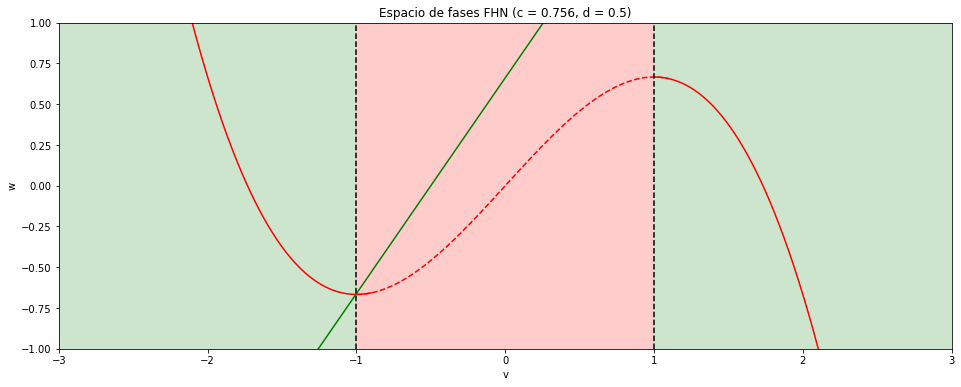

In [6]:
params = (0.756, 0.5)
v_vals_1 = np.arange(-3, -0.9, 0.001)
v_vals_2 = np.arange(-1, 1.1, 0.001)
v_vals_3 = np.arange(1, 3, 0.001)
v_vals = np.arange(-3, 3, 0.001)
w_vals = np.arange(-1, 1, 0.001)

fig = plt.figure(figsize = (16, 6))
ax = fig.add_subplot(111)

ax.set_title('Espacio de fases FHN (c = 0.756, d = 0.5)')
ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.plot(v_vals_1, [vNullcline(v) for v in v_vals_1], color = 'r')
ax.plot(v_vals_2, [vNullcline(v) for v in v_vals_2], color = 'r', linestyle = '--')
ax.plot(v_vals_3, [vNullcline(v) for v in v_vals_3], color = 'r')

ax.plot(v_vals, [wNullcline(params, v) for v in v_vals], color = 'g')
ax.axvline(-1, color='k', linestyle = '--')
ax.axvline(1, color='k', linestyle = '--')
ax.axvspan(-3, -1, facecolor = 'green', alpha = 0.2)
ax.axvspan(-1, 1, facecolor = 'red', alpha = 0.2)
ax.axvspan(1, 3, facecolor = 'green', alpha = 0.2);

## Espacio de fases para $ \epsilon = 0 $  ($ M_0 $)

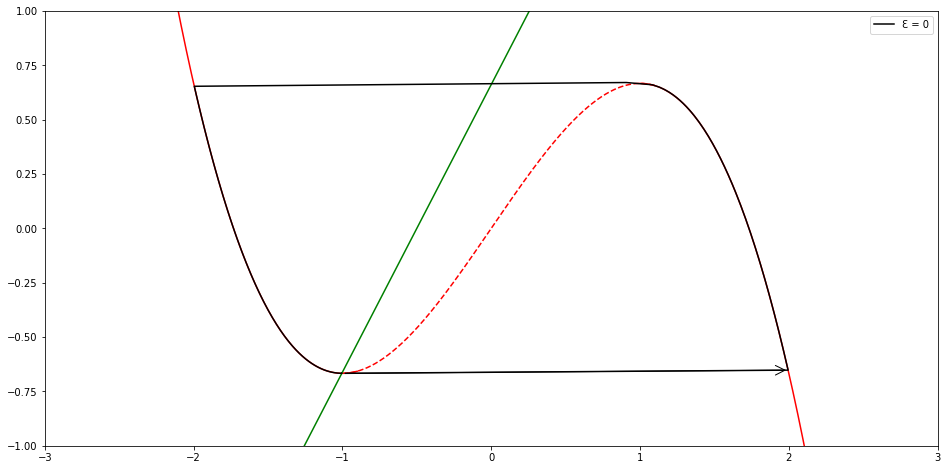

In [7]:
from math import sqrt
from scipy.integrate import odeint; 

#TODO
# See: https://stackoverflow.com/questions/23578596/solve-an-implicit-ode-differential-algebraic-equation-dae 
# Ver como resolver la eq 11 del paper que tiene un algebraic constraint con v.
t = np.arange(0.0, 20, 0.01)
params = (0.756, 0.5, 0.0001, 0)
X = odeint(st_FHN, np.array([-0.98, -2/3]), t, args = params)
#X = rungekutta4(st_FHN, (0.756, 0.5, 0, 0.0001), np.array([0.1158, 0.671]), 0.0001, 0.001)
params = (0.756, 0.5)

v_vals_1 = np.arange(-3, -0.9, 0.001)
v_vals_2 = np.arange(-1, 1.1, 0.001)
v_vals_3 = np.arange(1, 3, 0.001)
v_vals = np.arange(-3, 3, 0.001)
w_vals = np.arange(-1, 1, 0.001)

fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(111)

ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1)
ax.plot(v_vals_1, [vNullcline(v) for v in v_vals_1], color = 'r')
ax.plot(v_vals_2, [vNullcline(v) for v in v_vals_2], color = 'r', linestyle = '--')
ax.plot(v_vals_3, [vNullcline(v) for v in v_vals_3], color = 'r')

ax.plot(v_vals, [wNullcline(params, v) for v in v_vals], color = 'g')


manifold, = ax.plot(X[:,0], X[:,1], color = 'k', label = 'Ɛ = 0')
add_arrow(manifold, color = 'k')
    
ax.legend();

## Espacio de fases para distintos $ \epsilon $ ($ M_e $)

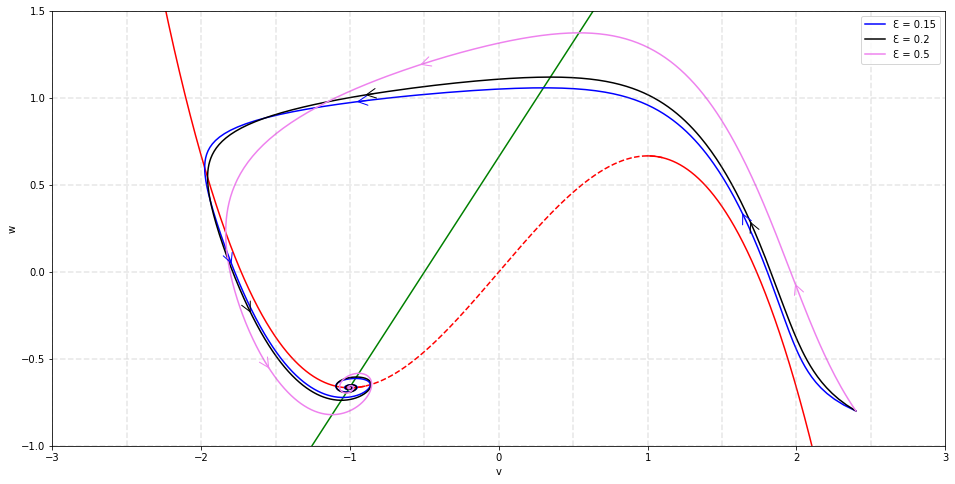

In [8]:
from math import sqrt
from scipy.integrate import odeint; 

t = np.arange(0.0, 20, 0.01)
params = (0.756, 0.5, 0.0001, 0)

epsilon_vals = [0.15, 0.2, 0.5]
manifolds = []
for epsilon in epsilon_vals:
    params = (0.756, 0.5, epsilon, 0)
    manifolds.append(odeint(st_FHN, np.array([2.4, -0.8]), t, args = params))

params = (0.756, 0.5)

v_vals_1 = np.arange(-3, -0.9, 0.001)
v_vals_2 = np.arange(-1, 1.1, 0.001)
v_vals_3 = np.arange(1, 3, 0.001)
v_vals = np.arange(-3, 3, 0.001)
w_vals = np.arange(-1, 1, 0.001)

fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(111)

ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1.5)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.plot(v_vals_1, [vNullcline(v) for v in v_vals_1], color = 'r')
ax.plot(v_vals_2, [vNullcline(v) for v in v_vals_2], color = 'r', linestyle = '--')
ax.plot(v_vals_3, [vNullcline(v) for v in v_vals_3], color = 'r')
ax.plot(v_vals, [wNullcline(params, v) for v in v_vals], color = 'g')

colors = ['b', 'k', 'violet']
for i in range(len(epsilon_vals)):
    manifold, = ax.plot(manifolds[i][:,0], manifolds[i][:,1], color = colors[i], label = 'Ɛ = ' + str(epsilon_vals[i]))
    add_arrow(manifold, color = colors[i], position = epsilon_vals[i]-1)
    add_arrow(manifold, color = colors[i], position = epsilon_vals[i]+1.5)
    add_arrow(manifold, color = colors[i], position = -1.8 + i/8)
    

ax.legend()
hlines = np.arange(-3, 3, 0.5)
vlines = np.arange(-3, 3, 0.5)
for i in range(len(hlines)):
    ax.axhline(hlines[i], color='grey', linestyle = '--', alpha = 0.2)
    ax.axvline(vlines[i], color = 'grey', linestyle = '--', alpha = 0.2)


## Simulación FHN para c = 0.756, d = 0.5

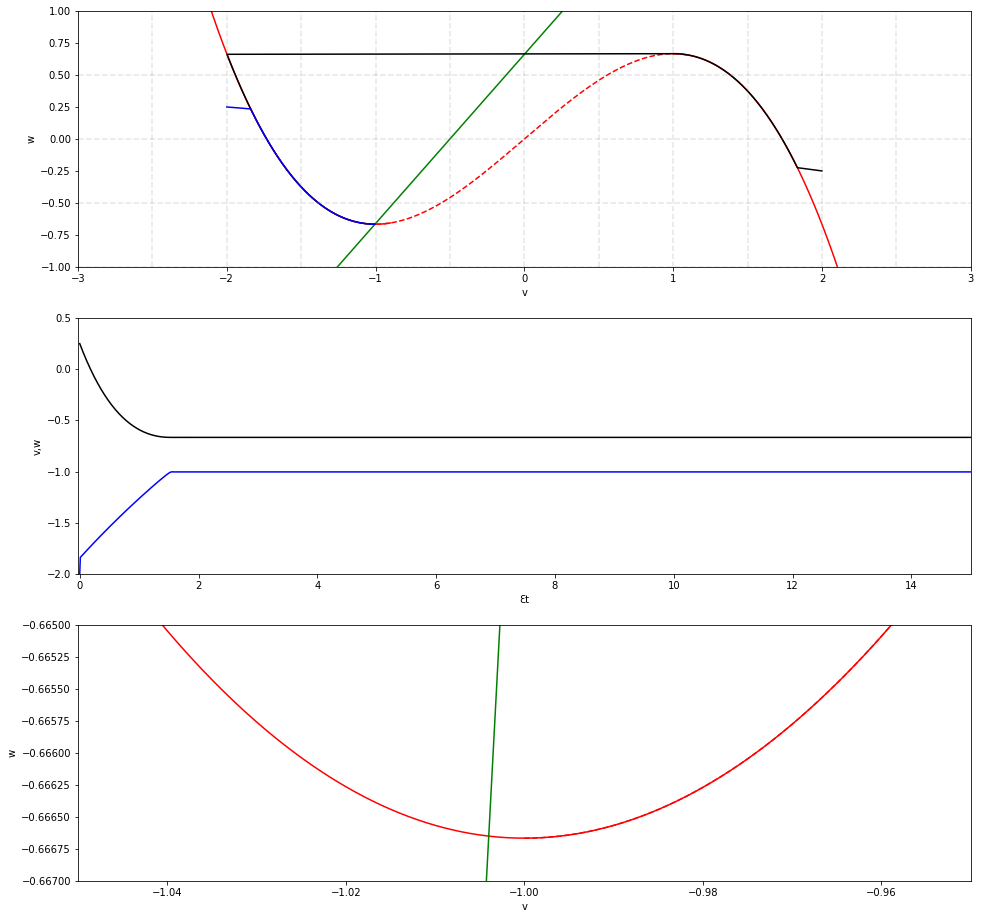

In [9]:
from math import sqrt
from scipy.integrate import odeint; 

t = np.arange(0.0, 20, 0.01)
params = (0.756, 0.5, 0.0001, 0)
X = odeint(st_FHN, np.array([2, -0.25]), t, args = params)
Y = odeint(st_FHN, np.array([-2, 0.25]), t, args = params)
#X = rungekutta4(st_FHN, (0.756, 0.5, 0, 0.0001), np.array([0.1158, 0.671]), 0.0001, 0.001)
params = (0.756, 0.5)

v_vals_1 = np.arange(-3, -0.9, 0.001)
v_vals_2 = np.arange(-1, 1.1, 0.001)
v_vals_3 = np.arange(1, 3, 0.001)
v_vals = np.arange(-3, 3, 0.001)
w_vals = np.arange(-1, 1, 0.001)

fig, (ax, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (16, 16))

ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.plot(v_vals_1, [vNullcline(v) for v in v_vals_1], color = 'r')
ax.plot(v_vals_2, [vNullcline(v) for v in v_vals_2], color = 'r', linestyle = '--')
ax.plot(v_vals_3, [vNullcline(v) for v in v_vals_3], color = 'r')

ax.plot(v_vals, [wNullcline(params, v) for v in v_vals], color = 'g')

ax.plot(X[:,0], X[:,1], color = 'k')
ax.plot(Y[:,0], Y[:,1], color = 'b')

hlines = np.arange(-3, 3, 0.5)
vlines = np.arange(-3, 3, 0.5)
for i in range(len(hlines)):
    ax.axhline(hlines[i], color='grey', linestyle = '--', alpha = 0.2)
    ax.axvline(vlines[i], color = 'grey', linestyle = '--', alpha = 0.2)
    

ax2.set_xlim(-0.03, 15)
ax2.set_ylim(-2, 0.5)
ax2.set_xlabel('Ɛt')
ax2.set_ylabel('v,w')
ax2.plot(t, Y[:,0], color = 'b')
ax2.plot(t, Y[:,1], color = 'k')

ax3.set_xlim(-1.05, -0.95)
ax3.set_ylim(-0.667, -0.665)
ax3.set_xlabel('v')
ax3.set_ylabel('w')
ax3.plot(v_vals_1, [vNullcline(v) for v in v_vals_1], color = 'r')
ax3.plot(v_vals_2, [vNullcline(v) for v in v_vals_2], color = 'r', linestyle = '--')
ax3.plot(v_vals_3, [vNullcline(v) for v in v_vals_3], color = 'r')
ax3.plot(v_vals, [wNullcline(params, v) for v in v_vals], color = 'g')


## Simulación FHN para c = 0.745, d = 0.5

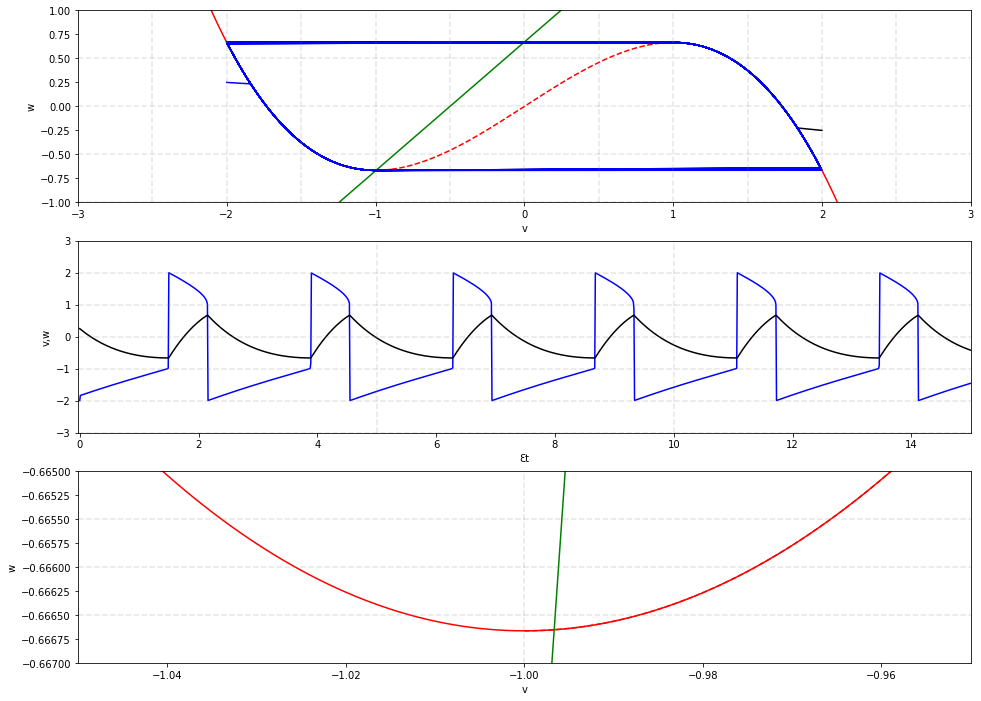

In [10]:
from math import sqrt
from scipy.integrate import odeint; 

t = np.arange(0.0, 20, 0.01)
params = (0.745, 0.5, 0.0001, 0)
X = odeint(st_FHN, np.array([2, -0.25]), t, args = params)
Y = odeint(st_FHN, np.array([-2, 0.25]), t, args = params)
#X = rungekutta4(st_FHN, (0.756, 0.5, 0, 0.0001), np.array([0.1158, 0.671]), 0.0001, 0.001)
params = (0.745, 0.5)

v_vals_1 = np.arange(-3, -0.9, 0.001)
v_vals_2 = np.arange(-1, 1.1, 0.001)
v_vals_3 = np.arange(1, 3, 0.001)
v_vals = np.arange(-3, 3, 0.001)
w_vals = np.arange(-1, 1, 0.001)

fig, (ax, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (16, 12))

ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.plot(v_vals_1, [vNullcline(v) for v in v_vals_1], color = 'r')
ax.plot(v_vals_2, [vNullcline(v) for v in v_vals_2], color = 'r', linestyle = '--')
ax.plot(v_vals_3, [vNullcline(v) for v in v_vals_3], color = 'r')

ax.plot(v_vals, [wNullcline(params, v) for v in v_vals], color = 'g')

ax.plot(X[:,0], X[:,1], color = 'k')
ax.plot(Y[:,0], Y[:,1], color = 'b')

hlines = np.arange(-3, 3, 0.5)
vlines = np.arange(-3, 3, 0.5)
for i in range(len(hlines)):
    ax.axhline(hlines[i], color='grey', linestyle = '--', alpha = 0.2)
    ax.axvline(vlines[i], color = 'grey', linestyle = '--', alpha = 0.2)

ax2.set_xlim(-0.03, 15)
ax2.set_ylim(-3, 3)
ax2.set_xlabel('Ɛt')
ax2.set_ylabel('v,w')
ax2.plot(t, Y[:,0], color = 'b')
ax2.plot(t, Y[:,1], color = 'k')

hlines = np.arange(-3, 3, 1)
vlines = np.arange(5, 15, 5)
for i in range(len(hlines)):
    ax2.axhline(hlines[i], color='grey', linestyle = '--', alpha = 0.2)
for i in range(len(vlines)):
    ax2.axvline(vlines[i], color = 'grey', linestyle = '--', alpha = 0.2)

ax3.set_xlim(-1.05, -0.95)
ax3.set_ylim(-0.667, -0.665)
ax3.set_xlabel('v')
ax3.set_ylabel('w')
ax3.plot(v_vals_1, [vNullcline(v) for v in v_vals_1], color = 'r')
ax3.plot(v_vals_2, [vNullcline(v) for v in v_vals_2], color = 'r', linestyle = '--')
ax3.plot(v_vals_3, [vNullcline(v) for v in v_vals_3], color = 'r')
ax3.plot(v_vals, [wNullcline(params, v) for v in v_vals], color = 'g')

hlines = np.arange(-0.6665, -0.665, 0.0005)
vlines = np.arange(-1, 0, 1)
for i in range(len(hlines)):
    ax3.axhline(hlines[i], color='grey', linestyle = '--', alpha = 0.2)
for i in range(len(vlines)):
    ax3.axvline(vlines[i], color = 'grey', linestyle = '--', alpha = 0.2)

### Intersection of $ w = k $ with $ M_0 $ sections

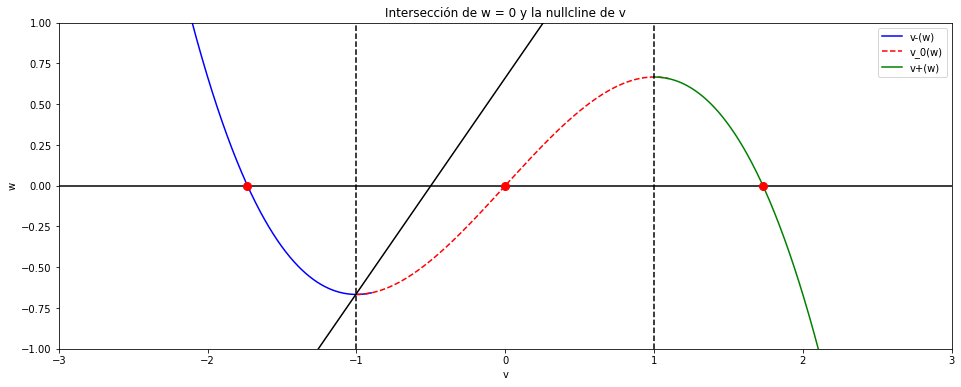

In [11]:
params = (0.756, 0.5)
v_vals_1 = np.arange(-3, -0.9, 0.001)
v_vals_2 = np.arange(-1, 1.1, 0.001)
v_vals_3 = np.arange(1, 3, 0.001)
v_vals = np.arange(-3, 3, 0.001)
w_vals = np.arange(-1, 1, 0.001)

fig = plt.figure(figsize = (16, 6))
ax = fig.add_subplot(111)

ax.set_title('Intersección de w = 0 y la nullcline de v')
ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.plot(v_vals_1, [vNullcline(v) for v in v_vals_1], color = 'b', label = 'v-(w)')
ax.plot(v_vals_2, [vNullcline(v) for v in v_vals_2], color = 'r', linestyle = '--', label = 'v_0(w)')
ax.plot(v_vals_3, [vNullcline(v) for v in v_vals_3], color = 'g', label = 'v+(w)')

ax.plot(v_vals, [wNullcline(params, v) for v in v_vals], color = 'k')
ax.axvline(-1, color='k', linestyle = '--')
ax.axvline(1, color='k', linestyle = '--')

ax.axhline(0, color='k')
ax.plot(-sqrt(3), 0, marker='o', markersize=8, color="red")
ax.plot(0, 0, marker='o', markersize=8, color="red")
ax.plot(sqrt(3), 0, marker='o', markersize=8, color="red")

ax.legend();

### Modelo de variable rápida en el límite $ \epsilon \rightarrow 0 $

<ipython-input-12-1e5cb6c4eb1d>:33: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  ax.annotate(' ΔU ±',
<ipython-input-12-1e5cb6c4eb1d>:69: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  ax2.annotate(' ΔU -',
<ipython-input-12-1e5cb6c4eb1d>:101: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  ax3.annotate(' ΔU +',


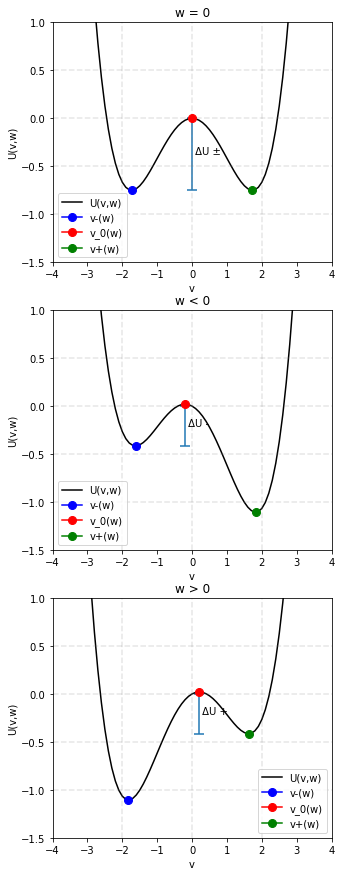

In [12]:
def U(v, w):
    return 1/12 * v**4 - 1/2 * v**2 + v*w


v_vals = np.arange(-4, 4, 0.1)
w = 0
results = []

for v in v_vals:
    results.append(U(v,w))


fig, (ax, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (5, 15))

ax.set_title("w = 0")
ax.set_xlim(-4, 4)
ax.set_ylim(-1.5, 1)
ax.set_xlabel('v')
ax.set_ylabel('U(v,w)')
ax.plot(v_vals, results, label = 'U(v,w)', color = 'k')
hlines = np.arange(-1, 1, 0.5)
vlines = np.arange(-2, 3, 2)
for i in range(len(hlines)):
    ax.axhline(hlines[i], color='grey', linestyle = '--', alpha = 0.2)
for i in range(len(vlines)):
    ax.axvline(vlines[i], color = 'grey', linestyle = '--', alpha = 0.2)

ax.plot(-sqrt(3), U(-sqrt(3), 0), marker='o', markersize = 8, color='b', label = 'v-(w)')
ax.plot(0, 0, marker='o', markersize=8, color='r', label = 'v_0(w)')
ax.plot(sqrt(3), U(sqrt(3), 0), marker='o', markersize=8, color='g', label = 'v+(w)')

ax.vlines(0, U(-sqrt(3), 0), 0, label = '')
ax.annotate(' ΔU ±', 
             xy=(0, U(-sqrt(3), 0)/2),  
             xycoords='data',
             textcoords='offset points')
ax.hlines(U(-sqrt(3), 0), -0.15, 0.15, label = '')
ax.hlines(0, -0.15, 0.15, label = '')

ax.legend()



w = -0.2
results = []

for v in v_vals:
    results.append(U(v,w))
    
ax2.set_title("w < 0")
ax2.set_xlim(-4, 4)
ax2.set_ylim(-1.5, 1)
ax2.set_xlabel('v')
ax2.set_ylabel('U(v,w)')
ax2.plot(v_vals, results, label = 'U(v,w)', color = 'k')
hlines = np.arange(-1, 1, 0.5)
vlines = np.arange(-2, 3, 2)
for i in range(len(hlines)):
    ax2.axhline(hlines[i], color='grey', linestyle = '--', alpha = 0.2)
for i in range(len(vlines)):
    ax2.axvline(vlines[i], color = 'grey', linestyle = '--', alpha = 0.2)

ax2.plot(-1.621, U(-1.62, w), marker='o', markersize=8, color='b', label = 'v-(w)')
ax2.plot(-0.202, U(-0.202, w), marker='o', markersize=8, color='r', label = 'v_0(w)')
ax2.plot(1.824, U(1.824, w), marker='o', markersize=8, color='g', label = 'v+(w)')

ax2.vlines(-0.202, U(-1.62, w), U(-0.202, w))

ax2.annotate(' ΔU -', 
             xy=(-0.202, U(-1.62, w)/2),  
             xycoords='data',
             textcoords='offset points')
ax2.hlines(U(-1.62, w), -0.202-0.15, -0.202+0.15, label = '')
ax2.hlines(0, -0.202-0.15, -0.202+0.15, label = '')
ax2.legend()

w = 0.2
results = []

for v in v_vals:
    results.append(U(v,w))
    
ax3.set_title("w > 0")
ax3.set_xlim(-4, 4)
ax3.set_ylim(-1.5, 1)
ax3.set_xlabel('v')
ax3.set_ylabel('U(v,w)')
ax3.plot(v_vals, results, label = 'U(v,w)', color = 'k')
hlines = np.arange(-1, 1, 0.5)
vlines = np.arange(-2, 3, 2)
for i in range(len(hlines)):
    ax3.axhline(hlines[i], color='grey', linestyle = '--', alpha = 0.2)
for i in range(len(vlines)):
    ax3.axvline(vlines[i], color = 'grey', linestyle = '--', alpha = 0.2)
    
ax3.plot(-1.824, U(-1.824, w), marker='o', markersize=8, color='b', label = 'v-(w)')
ax3.plot(0.202, U(0.202, w), marker='o', markersize=8, color='r', label = 'v_0(w)')
ax3.plot(1.621, U(1.621, w), marker='o', markersize=8, color='g', label = 'v+(w)')

ax3.vlines(0.202, U(1.621, w), U(0.202, w))
ax3.annotate(' ΔU +', 
             xy=(0.202, U(1.621, w)/2),  
             xycoords='data',
             textcoords='offset points')
ax3.hlines(U(1.621, w), 0.202-0.15, 0.202+0.15, label = '')
ax3.hlines(0, 0.202-0.15, 0.202+0.15, label = '')

ax3.legend();

### Simulaciones numéricas con ecuación rapida con $ \sigma = 0 $

In [13]:
params = (0.756, 0.5, 0.001, 0)
X = euler_ft_FHN(params, fast_f, fast_g, -2, 0.25, 0.0, 5000, 0.001)
#Y = euler_ft_FHN(params, fast_f, fast_g, 2, -0.25, 0.0, 5000, 0.001)


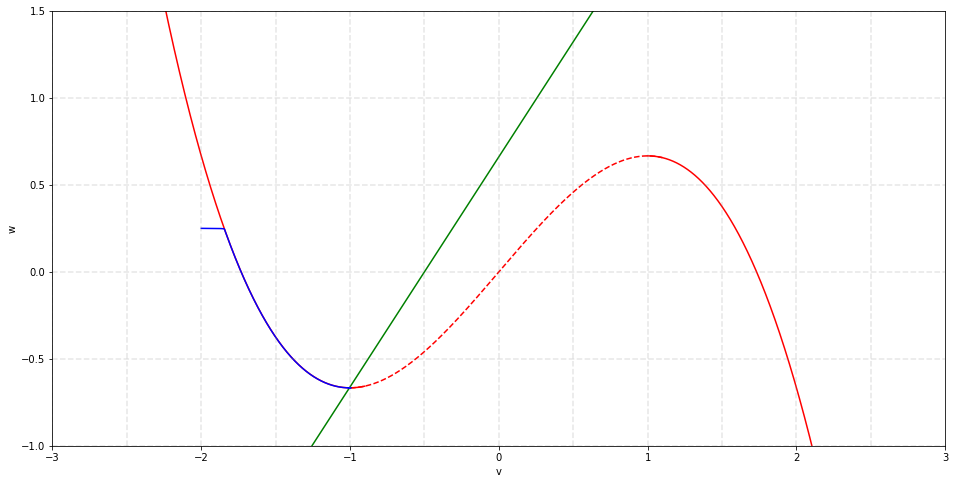

In [14]:
params = (0.756, 0.5)
v_vals_1 = np.arange(-3, -0.9, 0.001)
v_vals_2 = np.arange(-1, 1.1, 0.001)
v_vals_3 = np.arange(1, 3, 0.001)
v_vals = np.arange(-3, 3, 0.001)
w_vals = np.arange(-1, 1, 0.001)

fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(111)

ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.plot(v_vals_1, [vNullcline(v) for v in v_vals_1], color = 'r')
ax.plot(v_vals_2, [vNullcline(v) for v in v_vals_2], color = 'r', linestyle = '--')
ax.plot(v_vals_3, [vNullcline(v) for v in v_vals_3], color = 'r')

ax.plot(v_vals, [wNullcline(params, v) for v in v_vals], color = 'g')

#print(X)
ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1.5)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.plot(X[:,0], X[:,1], color = 'b')
#ax.plot(Y[:,0], Y[:,1], color = 'k')

hlines = np.arange(-3, 3, 0.5)
vlines = np.arange(-3, 3, 0.5)
for i in range(len(hlines)):
    ax.axhline(hlines[i], color='grey', linestyle = '--', alpha = 0.2)
    ax.axvline(vlines[i], color = 'grey', linestyle = '--', alpha = 0.2)

### Simulaciones numéricas con ecuación rapida con $ \sigma = 0.005 $

In [33]:
params = (0.76, 0.5, 0.0001, 0.005)
try:
    X_1 = np.genfromtxt('fig7_1.csv', delimiter=',')
except:
    X_1 = euler_ft_FHN(params, fast_f, fast_g, -2, 0.25, 0.0, 100000, 0.1)

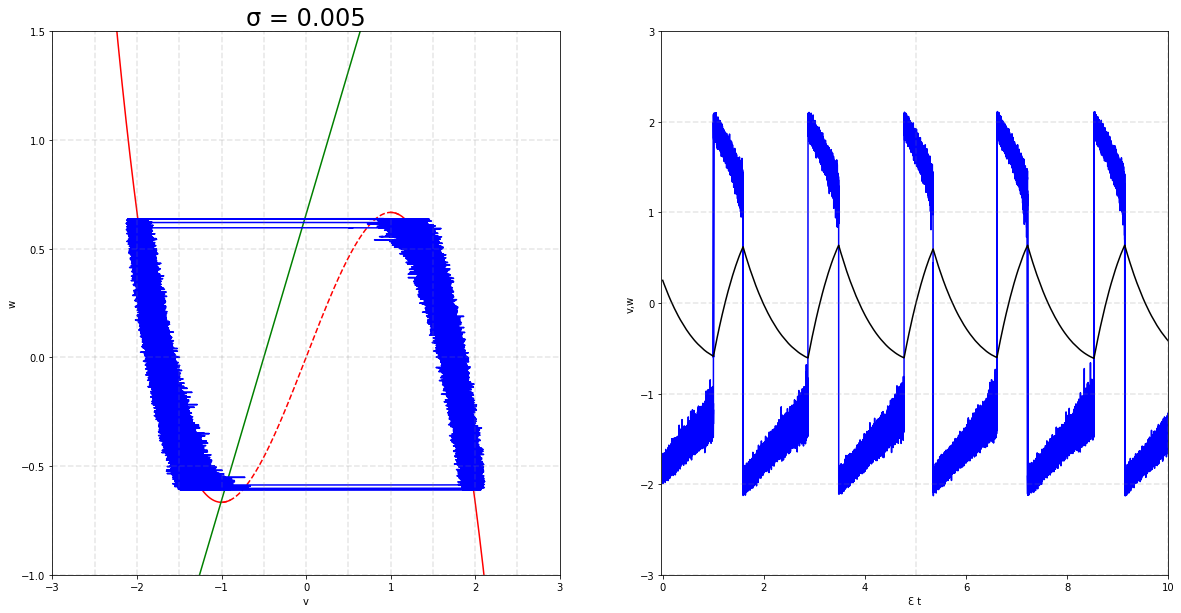

In [35]:
epsilon = 0.0001
eps_t = np.arange(0.0, epsilon*100000.001, epsilon*0.1)
params = (0.76, 0.5)
v_vals_1 = np.arange(-3, -0.9, 0.001)
v_vals_2 = np.arange(-1, 1.1, 0.001)
v_vals_3 = np.arange(1, 3, 0.001)
v_vals = np.arange(-3, 3, 0.001)
w_vals = np.arange(-1, 1, 0.001)

fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))


ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.plot(v_vals_1, [vNullcline(v) for v in v_vals_1], color = 'r')
ax.plot(v_vals_2, [vNullcline(v) for v in v_vals_2], color = 'r', linestyle = '--')
ax.plot(v_vals_3, [vNullcline(v) for v in v_vals_3], color = 'r')

ax.plot(v_vals, [wNullcline(params, v) for v in v_vals], color = 'g')

#print(X)
ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1.5)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.set_title ('σ = 0.005', fontsize = 24)
ax.plot(X_1[:,0], X_1[:,1], color = 'b')

hlines = np.arange(-3, 3, 0.5)
vlines = np.arange(-3, 3, 0.5)
for i in range(len(hlines)):
    ax.axhline(hlines[i], color='grey', linestyle = '--', alpha = 0.2)
    ax.axvline(vlines[i], color = 'grey', linestyle = '--', alpha = 0.2)

ax2.set_xlim(-0.03, 10)
ax2.set_ylim(-3, 3)
ax2.set_xlabel('Ɛ t')
ax2.set_ylabel('v,w')
ax2.plot(eps_t, X_1[:,0], color = 'b')
ax2.plot(eps_t, X_1[:,1], color = 'k')

hlines = np.arange(-3, 3, 1)
vlines = np.arange(5, 15, 5)
for i in range(len(hlines)):
    ax2.axhline(hlines[i], color='grey', linestyle = '--', alpha = 0.2)
for i in range(len(vlines)):
    ax2.axvline(vlines[i], color = 'grey', linestyle = '--', alpha = 0.2)
        
        
np.savetxt("fig7_1.csv", X_1, delimiter=",");
del X_1, ax, ax2, fig, eps_t, v_vals_1, v_vals_2, v_vals_3, v_vals, w_vals

### Simulaciones numéricas con ecuación rapida con $ \sigma = 0.01 $

In [38]:
params = (0.76, 0.5, 0.0001, 0.01)
try:
    X_2 = np.genfromtxt('fig7_2.csv', delimiter=',')
except:
    X_2 = euler_ft_FHN(params, fast_f, fast_g, -2, 0.25, 0.0, 100000, 0.1)

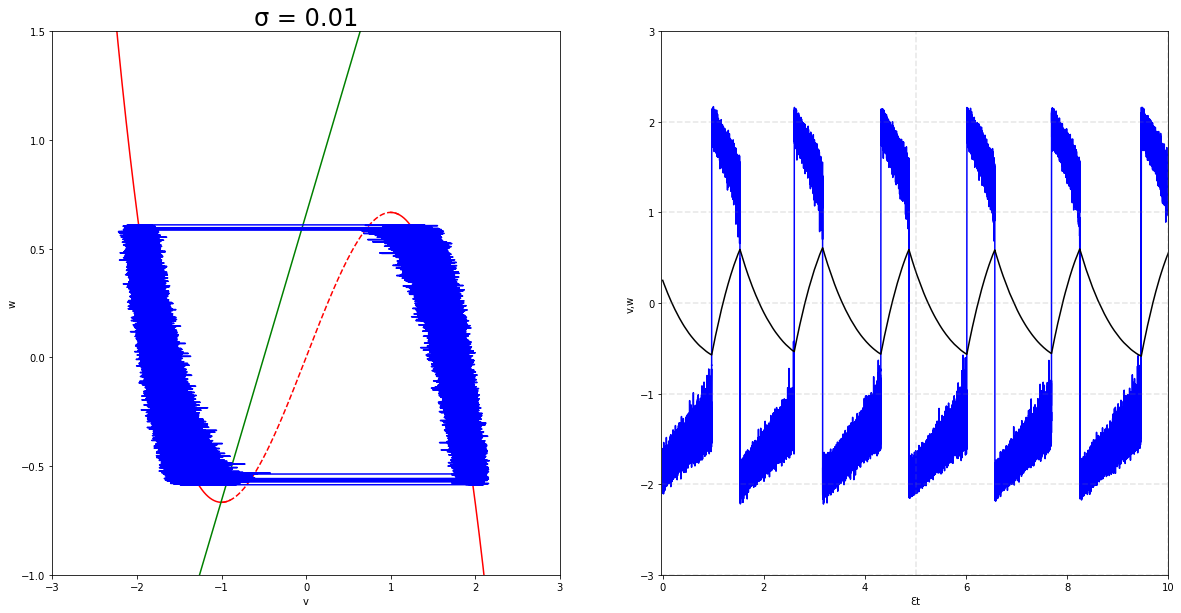

In [39]:
epsilon = 0.0001
eps_t = np.arange(0.0, epsilon*100000.001, epsilon*0.1)
params = (0.76, 0.5)
v_vals_1 = np.arange(-3, -0.9, 0.001)
v_vals_2 = np.arange(-1, 1.1, 0.001)
v_vals_3 = np.arange(1, 3, 0.001)
v_vals = np.arange(-3, 3, 0.001)
w_vals = np.arange(-1, 1, 0.001)

fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))


ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.plot(v_vals_1, [vNullcline(v) for v in v_vals_1], color = 'r')
ax.plot(v_vals_2, [vNullcline(v) for v in v_vals_2], color = 'r', linestyle = '--')
ax.plot(v_vals_3, [vNullcline(v) for v in v_vals_3], color = 'r')

ax.plot(v_vals, [wNullcline(params, v) for v in v_vals], color = 'g')

#print(X)
ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1.5)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.plot(X_2[:,0], X_2[:,1], color = 'b')
ax.set_title ('σ = 0.01', fontsize = 24)
#ax.plot(Y[:,0], Y[:,1], color = 'k');

ax2.set_xlim(-0.03, 10)
ax2.set_ylim(-3, 3)
ax2.set_xlabel('Ɛt')
ax2.set_ylabel('v,w')
ax2.plot(eps_t, X_2[:,0], color = 'b')
ax2.plot(eps_t, X_2[:,1], color = 'k')

hlines = np.arange(-3, 3, 1)
vlines = np.arange(5, 15, 5)
for i in range(len(hlines)):
    ax2.axhline(hlines[i], color='grey', linestyle = '--', alpha = 0.2)
for i in range(len(vlines)):
    ax2.axvline(vlines[i], color = 'grey', linestyle = '--', alpha = 0.2)
        
np.savetxt("fig7_2.csv", X_2, delimiter=",")
del X_2, ax, ax2, fig, eps_t, v_vals_1, v_vals_2, v_vals_3, v_vals, w_vals

### Simulaciones numéricas con ecuación rapida con $ \sigma = 0.03 $

In [40]:
from math import sqrt
import math


params = (0.76, 0.5, 0.0001, 0.03)
try:
    X_3 = np.genfromtxt('fig7_3.csv', delimiter=',')
except:
    X_3 = euler_ft_FHN(params, fast_f, fast_g, -2, 0.25, 0.0, 100000, 0.1)

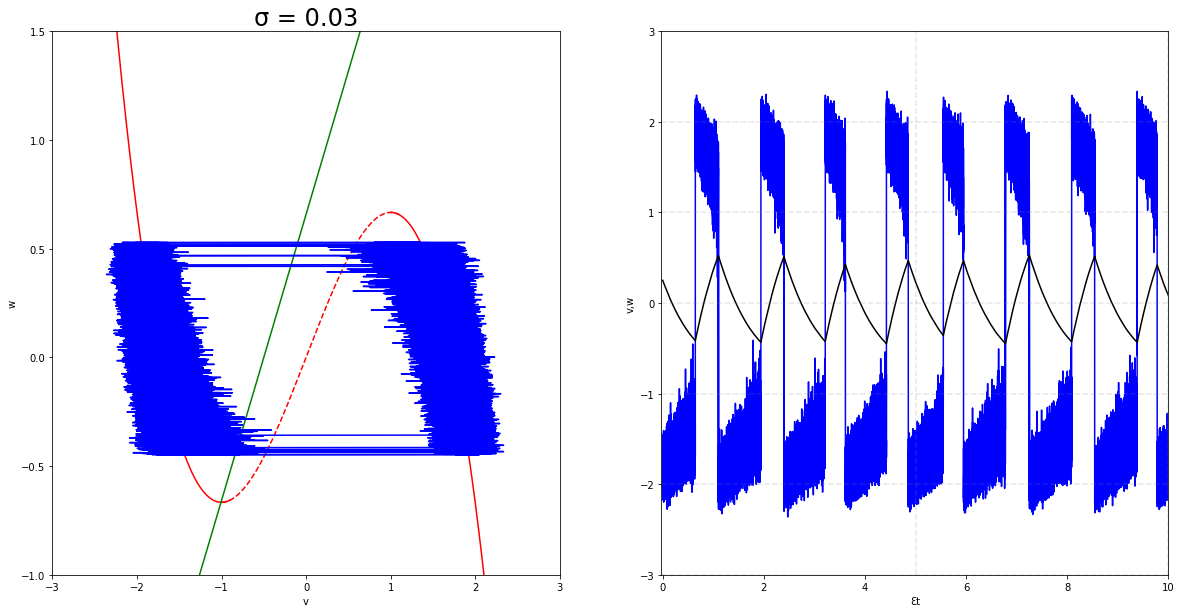

In [42]:
epsilon = 0.0001
eps_t = np.arange(0.0, epsilon*100000.001, epsilon*0.1)
params = (0.76, 0.5)
v_vals_1 = np.arange(-3, -0.9, 0.001)
v_vals_2 = np.arange(-1, 1.1, 0.001)
v_vals_3 = np.arange(1, 3, 0.001)
v_vals = np.arange(-3, 3, 0.001)
w_vals = np.arange(-1, 1, 0.001)

fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))


ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1)
ax.set_xlabel('v')
ax.set_ylabel('w')

ax.plot(v_vals_1, [vNullcline(v) for v in v_vals_1], color = 'r')
ax.plot(v_vals_2, [vNullcline(v) for v in v_vals_2], color = 'r', linestyle = '--')
ax.plot(v_vals_3, [vNullcline(v) for v in v_vals_3], color = 'r')

ax.plot(v_vals, [wNullcline(params, v) for v in v_vals], color = 'g')

#print(X)
ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1.5)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.plot(X_3[:,0], X_3[:,1], color = 'b')
ax.set_title ('σ = 0.03', fontsize = 24)
#ax.plot(Y[:,0], Y[:,1], color = 'k');

ax2.set_xlim(-0.03, 10)
ax2.set_ylim(-3, 3)
ax2.set_xlabel('Ɛt')
ax2.set_ylabel('v,w')
ax2.plot(eps_t, X_3[:,0], color = 'b')
ax2.plot(eps_t, X_3[:,1], color = 'k')

hlines = np.arange(-3, 3, 1)
vlines = np.arange(5, 15, 5)
for i in range(len(hlines)):
    ax2.axhline(hlines[i], color='grey', linestyle = '--', alpha = 0.2)
for i in range(len(vlines)):
    ax2.axvline(vlines[i], color = 'grey', linestyle = '--', alpha = 0.2)
    
np.savetxt("fig7_3.csv", X_3, delimiter=",")
del X_3, ax, ax2, fig, eps_t, v_vals_1, v_vals_2, v_vals_3, v_vals, w_vals

### Simulaciones numéricas con ecuación rapida con $ \epsilon = 0.0005 $ y $ \sigma = 0.01 $

In [43]:
params = (0.76, 0.5, 0.0005, 0.01)
try:
    X_4 = np.genfromtxt('fig8_1.csv', delimiter=',')
except:
    X_4 = euler_ft_FHN(params, fast_f, fast_g, -2, 0.25, 0.0, 30000, 0.1)

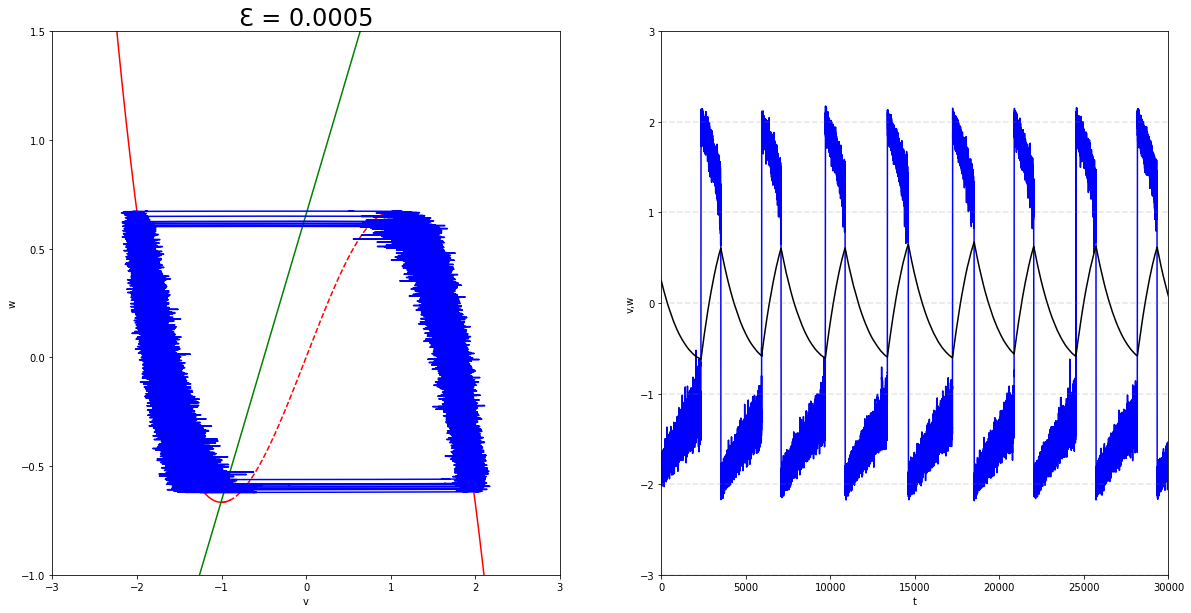

In [45]:
epsilon = 0.0005
eps_t = np.arange(0.0, epsilon*30000.001, epsilon*0.1)
t = np.arange(0.0, 30000.01, 0.1)
params = (0.76, 0.5)
v_vals_1 = np.arange(-3, -0.9, 0.001)
v_vals_2 = np.arange(-1, 1.1, 0.001)
v_vals_3 = np.arange(1, 3, 0.001)
v_vals = np.arange(-3, 3, 0.001)
w_vals = np.arange(-1, 1, 0.001)

fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))


ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.plot(v_vals_1, [vNullcline(v) for v in v_vals_1], color = 'r')
ax.plot(v_vals_2, [vNullcline(v) for v in v_vals_2], color = 'r', linestyle = '--')
ax.plot(v_vals_3, [vNullcline(v) for v in v_vals_3], color = 'r')
ax.set_title("Ɛ = 0.0005", fontsize = 24)

ax.plot(v_vals, [wNullcline(params, v) for v in v_vals], color = 'g')

#print(X)
ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1.5)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.plot(X_4[:,0], X_4[:,1], color = 'b')
#ax.plot(Y[:,0], Y[:,1], color = 'k');

ax2.set_xlim(-0.03, 30000)
ax2.set_ylim(-3, 3)
ax2.set_xlabel('t')
ax2.set_ylabel('v,w')
ax2.plot(t, X_4[:,0], color = 'b')
ax2.plot(t, X_4[:,1], color = 'k')

hlines = np.arange(-3, 3, 1)
vlines = np.arange(5, 15, 5)
for i in range(len(hlines)):
    ax2.axhline(hlines[i], color='grey', linestyle = '--', alpha = 0.2)
for i in range(len(vlines)):
    ax2.axvline(vlines[i], color = 'grey', linestyle = '--', alpha = 0.2)
    
np.savetxt("fig8_1.csv", X_4, delimiter=",")
del X_4, ax, ax2, fig, eps_t, v_vals_1, v_vals_2, v_vals_3, v_vals, w_vals

### Simulaciones numéricas con ecuación rapida con $ \epsilon = 0.001 $ y $ \sigma = 0.01 $

In [46]:
params = (0.76, 0.5, 0.001, 0.01)
try:
    X_5 = np.genfromtxt('fig8_2.csv', delimiter=',')
except:
    X_5 = euler_ft_FHN(params, fast_f, fast_g, -2, 0.25, 0.0, 30000, 0.1)

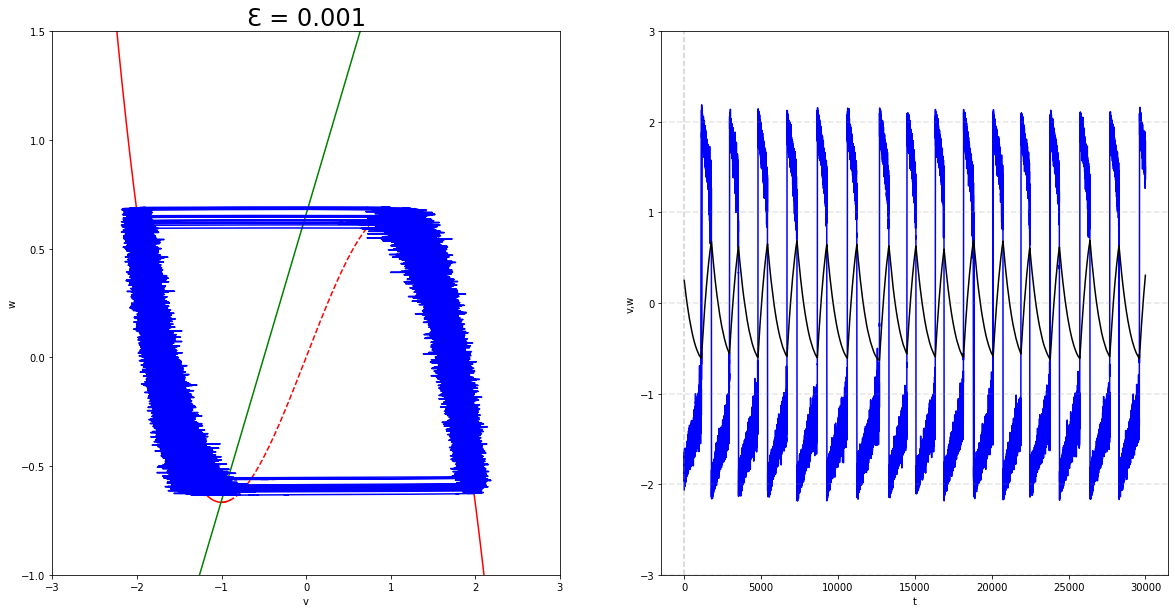

In [47]:
epsilon = 0.001
eps_t = np.arange(0.0, epsilon*30000.001, epsilon*0.1)
t = np.arange(0.0, 30000.01, 0.1)
params = (0.76, 0.5)
v_vals_1 = np.arange(-3, -0.9, 0.001)
v_vals_2 = np.arange(-1, 1.1, 0.001)
v_vals_3 = np.arange(1, 3, 0.001)
v_vals = np.arange(-3, 3, 0.001)
w_vals = np.arange(-1, 1, 0.001)

fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))


ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.plot(v_vals_1, [vNullcline(v) for v in v_vals_1], color = 'r')
ax.plot(v_vals_2, [vNullcline(v) for v in v_vals_2], color = 'r', linestyle = '--')
ax.plot(v_vals_3, [vNullcline(v) for v in v_vals_3], color = 'r')

ax.plot(v_vals, [wNullcline(params, v) for v in v_vals], color = 'g')

#print(X)
ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1.5)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.plot(X_5[:,0], X_5[:,1], color = 'b')
ax.set_title("Ɛ = 0.001", fontsize = 24)
#ax.plot(Y[:,0], Y[:,1], color = 'k');

#ax2.set_xlim(-0.03, 3 * 10**4)
ax2.set_ylim(-3, 3)
ax2.set_xlabel('t')
ax2.set_ylabel('v,w')
ax2.plot(t, X_5[:,0], color = 'b')
ax2.plot(t, X_5[:,1], color = 'k')

hlines = np.arange(-3, 3, 1)
vlines = np.arange(5, 15, 5)
for i in range(len(hlines)):
    ax2.axhline(hlines[i], color='grey', linestyle = '--', alpha = 0.2)
for i in range(len(vlines)):
    ax2.axvline(vlines[i], color = 'grey', linestyle = '--', alpha = 0.2)
    
    
np.savetxt("fig8_2.csv", X_5, delimiter=",")
del X_5, ax, ax2, fig, eps_t, v_vals_1, v_vals_2, v_vals_3, v_vals, w_vals

### Simulaciones numéricas con ecuación rapida con $ \epsilon = 0.002 $ y $ \sigma = 0.01 $

In [48]:
params = (0.76, 0.5, 0.002, 0.01)
try:
    X_6 = np.genfromtxt('fig8_3.csv', delimiter=',')
except:
    X_6 = euler_ft_FHN(params, fast_f, fast_g, -2, 0.25, 0.0, 30000, 0.1)

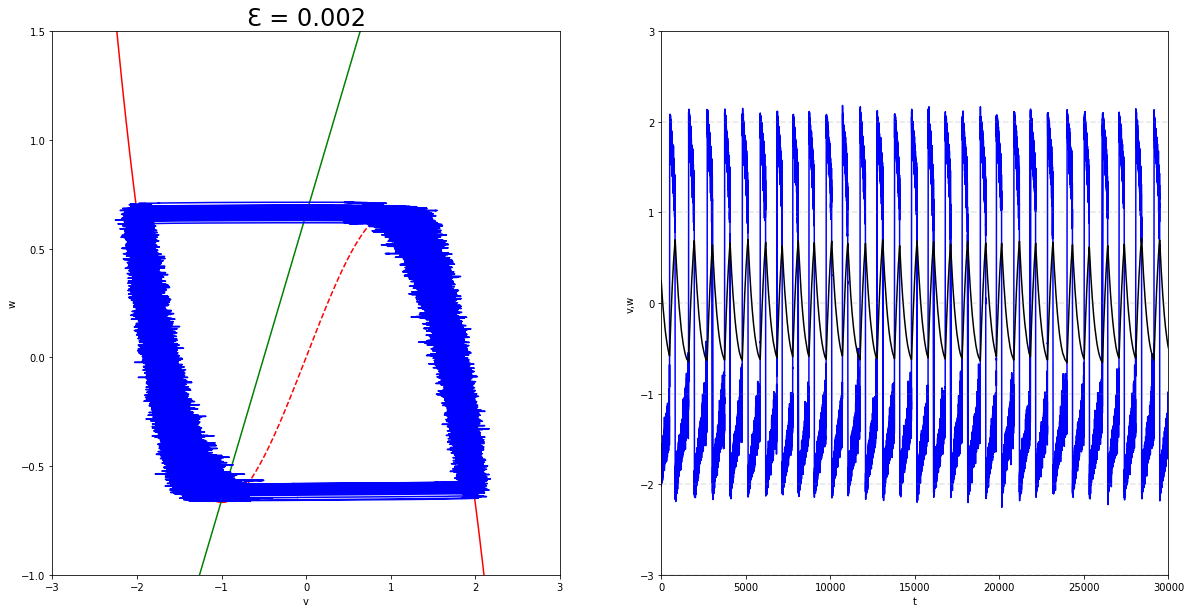

In [49]:
epsilon = 0.002
eps_t = np.arange(0.0, epsilon*30000.001, epsilon*0.1)
t = np.arange(0.0, 30000.01, 0.1)
params = (0.76, 0.5)
v_vals_1 = np.arange(-3, -0.9, 0.001)
v_vals_2 = np.arange(-1, 1.1, 0.001)
v_vals_3 = np.arange(1, 3, 0.001)
v_vals = np.arange(-3, 3, 0.001)
w_vals = np.arange(-1, 1, 0.001)

fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))


ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.plot(v_vals_1, [vNullcline(v) for v in v_vals_1], color = 'r')
ax.plot(v_vals_2, [vNullcline(v) for v in v_vals_2], color = 'r', linestyle = '--')
ax.plot(v_vals_3, [vNullcline(v) for v in v_vals_3], color = 'r')

ax.plot(v_vals, [wNullcline(params, v) for v in v_vals], color = 'g')

#print(X)
ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1.5)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.plot(X_6[:,0], X_6[:,1], color = 'b')
ax.set_title("Ɛ = 0.002", fontsize = 24)
#ax.plot(Y[:,0], Y[:,1], color = 'k');

ax2.set_xlim(-0.03, 3 * 10**4)
ax2.set_ylim(-3, 3)
ax2.set_xlabel('t')
ax2.set_ylabel('v,w')
ax2.plot(t, X_6[:,0], color = 'b')
ax2.plot(t, X_6[:,1], color = 'k')

hlines = np.arange(-3, 3, 1)
vlines = np.arange(5, 15, 5)
for i in range(len(hlines)):
    ax2.axhline(hlines[i], color='grey', linestyle = '--', alpha = 0.2)
for i in range(len(vlines)):
    ax2.axvline(vlines[i], color = 'grey', linestyle = '--', alpha = 0.2)
    
np.savetxt("fig8_3.csv", X_6, delimiter=",")
del X_6, ax, ax2, fig, eps_t, v_vals_1, v_vals_2, v_vals_3, v_vals, w_vals

### Intervalo incoherente (Poisson)

In [50]:
#(c, d, epsilon, sigma) = params 
#def euler_ft_FHN(params, f, g, v0, w0, a, b, h):

c = 0.76 
d = 0.5
epsilon = 0.0001
sigma = 1.55 * 10**(-7)
init_v = -2
init_w = 0.25
t_init = 0.0
t_end = 500000
steps = 0.1
params = (c, d, epsilon, sigma)
try:
    X_7 = np.genfromtxt('fig6_1.csv', delimiter=',')
except:
    X_7 = euler_ft_FHN(params, fast_f, fast_g, init_v, init_w, t_init, t_end, steps)

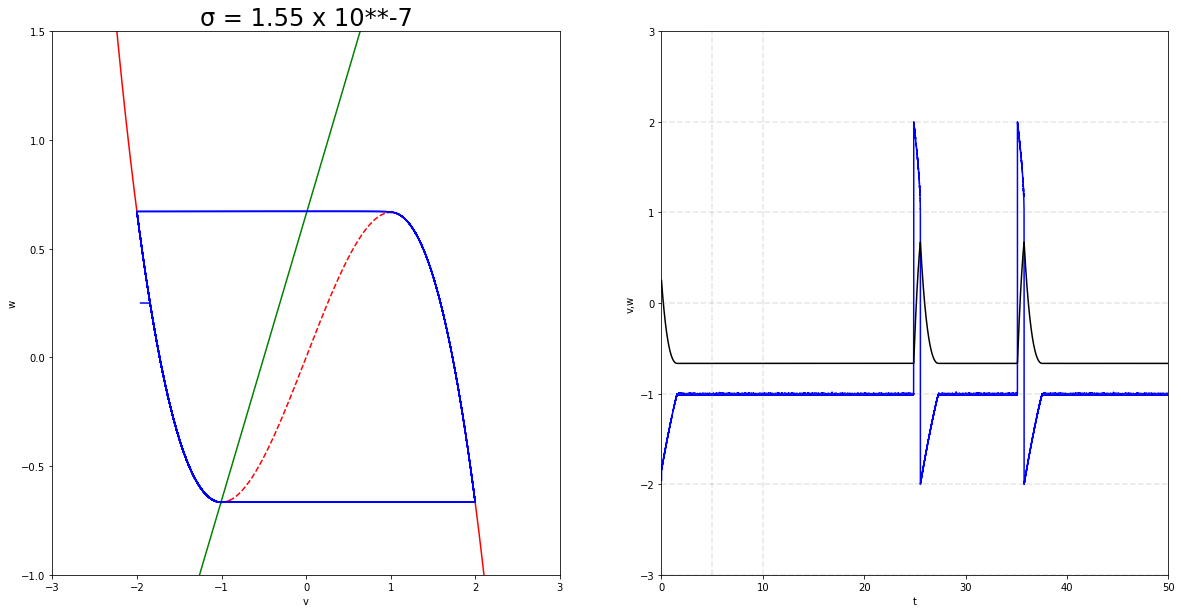

In [51]:
epsilon = 0.0001
eps_t = np.arange(0.0, epsilon*500000.001, epsilon*0.1)
t = np.arange(0.0, 100000.01, 0.1)
params = (0.76, 0.5)
v_vals_1 = np.arange(-3, -0.9, 0.001)
v_vals_2 = np.arange(-1, 1.1, 0.001)
v_vals_3 = np.arange(1, 3, 0.001)
v_vals = np.arange(-3, 3, 0.001)
w_vals = np.arange(-1, 1, 0.001)

fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))


ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.plot(v_vals_1, [vNullcline(v) for v in v_vals_1], color = 'r')
ax.plot(v_vals_2, [vNullcline(v) for v in v_vals_2], color = 'r', linestyle = '--')
ax.plot(v_vals_3, [vNullcline(v) for v in v_vals_3], color = 'r')

ax.plot(v_vals, [wNullcline(params, v) for v in v_vals], color = 'g')

#print(X)
ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1.5)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.plot(X_7[:,0], X_7[:,1], color = 'b')
ax.set_title("σ = 1.55 x 10**-7", fontsize = 24)
#ax.plot(Y[:,0], Y[:,1], color = 'k');

ax2.set_xlim(-0.03, 50)
ax2.set_ylim(-3, 3)
ax2.set_xlabel('t')
ax2.set_ylabel('v,w')
ax2.plot(eps_t, X_7[:,0], color = 'b')
ax2.plot(eps_t, X_7[:,1], color = 'k')

hlines = np.arange(-3, 3, 1)
vlines = np.arange(5, 15, 5)
for i in range(len(hlines)):
    ax2.axhline(hlines[i], color='grey', linestyle = '--', alpha = 0.2)
for i in range(len(vlines)):
    ax2.axvline(vlines[i], color = 'grey', linestyle = '--', alpha = 0.2)
    
np.savetxt("fig6_1.csv", X_7, delimiter=",")
del X_7, ax, ax2, fig, eps_t, v_vals_1, v_vals_2, v_vals_3, v_vals, w_vals

### Simulations for CV and ISI

In [74]:
epsilon_vals = [0.0001, 0.0005, 0.001, 0.01]
sigma_vals = [10**-7, 
              0.25*10**-6, 0.5*10**-6, 0.75*10**-6, 10**-6, 
              0.25*10**-5, 0.5*10**-5, 0.75*10**-5, 10**-5,
              0.25*10**-4, 0.5*10**-4, 0.75*10**-4, 10**-4,
              0.25*10**-3, 0.5*10**-3, 0.75*10**-3, 10**-3,
              0.25*10**-2, 0.5*10**-2, 0.75*10**-2, 10**-2,
              0.25*10**-1, 0.5*10**-1, 0.75*10**-1, 10**-1]
results = []
for epsilon in epsilon_vals:
    for sigma in sigma_vals:
        # X_6 = euler_ft_FHN(params, fast_f, fast_g, -2, 0.25, 0.0, 30000, 0.1)
        # params = (0.76, 0.5, 0.002, 0.01)
        c = 0.76 
        d = 0.5
        init_v = -2
        init_w = 0.25
        t_init = 0.0
        t_end = 300000
        steps = 0.1
        params = (c, d, epsilon, sigma)
        X = euler_ft_FHN(params, fast_f, fast_g, init_v, init_w, t_init, t_end, steps)
        
        #eps_t = np.arange(0.0, epsilon*(t_end + steps), epsilon*steps)
        t = np.arange(0.0, t_end + steps, steps)
        
        #plt.plot(eps_t, X[:,0], color = 'b')
        #plt.plot(eps_t, X[:,1], color = 'k')
        #plt.show()
        #ISI
        isi_1 = []
        offset = 100
        for i in range(len(X[:,0]) - 1):
            v = X[i,0]
            v_pl = X[i+1,0]
            try:
                v_fut = X[i+offset, 0]
            except:
                v_fut = v_pl
            if(v < 0 and v_pl > 0 and v_fut > 0):
                isi_1.append(t[i])
        
        intervals = []
        squared_intervals = []
        for i in range(len(isi_1) - 1):
            interval =  (isi_1[i+1] - isi_1[i])
            intervals.append(interval)
            squared_intervals.append(interval**2)
    
        intervals_mean = np.mean(intervals)
        squared_intervals_mean = np.mean(squared_intervals)
        intervals_sd = np.std(intervals)
        
        CV = None
        if(not math.isnan(intervals_mean) and not math.isnan(intervals_sd)):
            res = squared_intervals_mean - intervals_mean**2
            if res > 0:
                CV = math.sqrt(res) / intervals_mean
            
        values = {"Epsilon": epsilon, "Sigma": sigma, "Mean": intervals_mean, "SD": intervals_sd, "CV": CV, "Intervals": intervals}
        #print(values)
        results.append(values)
        #print("------------")

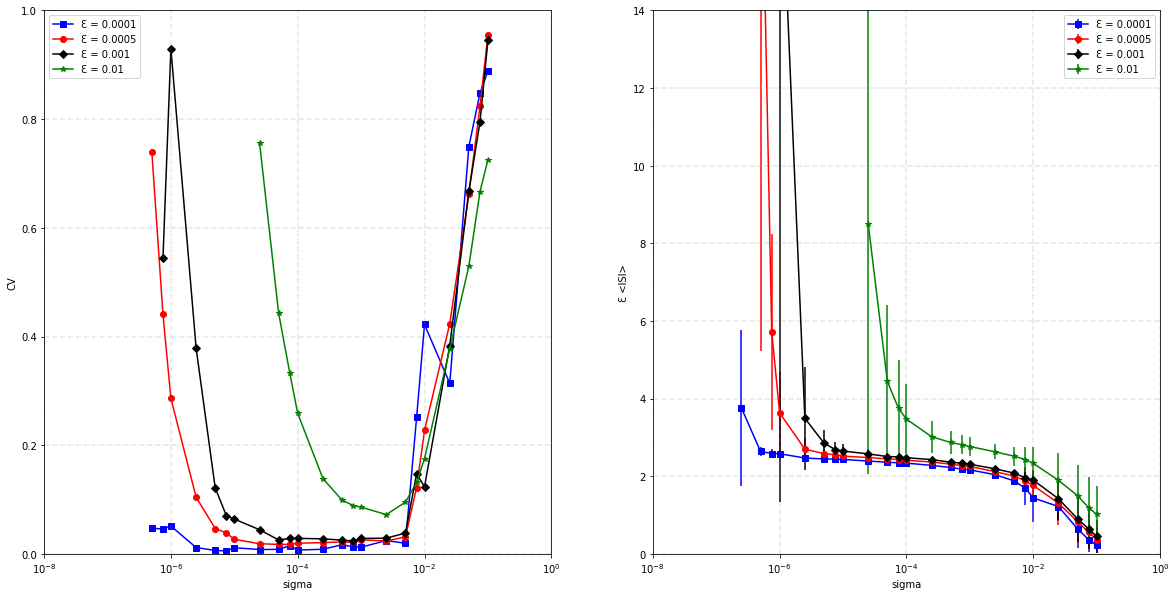

In [75]:
eps_1 = [x for x in results if x['Epsilon'] == 0.0001]
eps_2 = [x for x in results if x['Epsilon'] == 0.0005] 
eps_3 = [x for x in results if x['Epsilon'] == 0.001] 
eps_4 = [x for x in results if x['Epsilon'] == 0.01] 

fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))

ax.set_xlim(10**-8, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('sigma')
ax.set_ylabel('CV')
ax.set_xscale('log')
sigma_1 = [x['Sigma'] for x in eps_1]
cv_1 = [x['CV'] for x in eps_1]
sigma_2 = [x['Sigma'] for x in eps_2]
cv_2 = [x['CV'] for x in eps_2]
sigma_3 = [x['Sigma'] for x in eps_3]
cv_3 = [x['CV'] for x in eps_3]
sigma_4 = [x['Sigma'] for x in eps_4]
cv_4 = [x['CV'] for x in eps_4]

ax.plot(sigma_1[2:], cv_1[2:], color = 'b', marker = 's', label = 'Ɛ = 0.0001')
ax.plot(sigma_2[2:], cv_2[2:], color = 'r', marker = 'o', label = 'Ɛ = 0.0005')
ax.plot(sigma_3[3:], cv_3[3:], color = 'k', marker = 'D', label = 'Ɛ = 0.001')
ax.plot(sigma_4[9:], cv_4[9:], color = 'g', marker = '*', label = 'Ɛ = 0.01')

vlines = np.logspace(-8, 0, num = 5)
hlines = np.arange(0, 1, 0.2)
for i in range(len(hlines)):
    ax.axhline(hlines[i], color='grey', linestyle = '--', alpha = 0.2)
for i in range(len(vlines)):
    ax.axvline(vlines[i], color = 'grey', linestyle = '--', alpha = 0.2)
    
ax.legend();

ax2.set_xlim(10**-8, 1)
ax2.set_ylim(0, 14)
ax2.set_xlabel('sigma')
ax2.set_ylabel('Ɛ <ISI>')
ax2.set_xscale('log')
sigma_1 = [x['Sigma'] for x in eps_1]
mean_1 = [x['Mean']*x['Epsilon'] for x in eps_1]
sd_1 = [x['SD']*x['Epsilon'] for x in eps_1]

sigma_2 = [x['Sigma'] for x in eps_2]
mean_2 = [x['Mean']*x['Epsilon'] for x in eps_2]
sd_2 = [x['SD']*x['Epsilon'] for x in eps_2]

sigma_3 = [x['Sigma'] for x in eps_3]
mean_3 = [x['Mean']*x['Epsilon'] for x in eps_3]
sd_3 = [x['SD']*x['Epsilon'] for x in eps_3]

sigma_4 = [x['Sigma'] for x in eps_4]
mean_4 = [x['Mean']*x['Epsilon'] for x in eps_4]
sd_4 = [x['SD']*x['Epsilon'] for x in eps_4]

ax2.errorbar(sigma_1[1:], mean_1[1:], yerr = sd_1[1:], color = 'b', marker = 's', label = 'Ɛ = 0.0001')
ax2.errorbar(sigma_2[2:], mean_2[2:], yerr = sd_2[2:], color = 'r', marker = 'o', label = 'Ɛ = 0.0005')
ax2.errorbar(sigma_3[4:], mean_3[4:], yerr = sd_3[4:], color = 'k', marker = 'D', label = 'Ɛ = 0.001')
ax2.errorbar(sigma_4[9:], mean_4[9:], yerr = sd_4[9:], color = 'g', marker = '*', label = 'Ɛ = 0.01')

vlines = np.logspace(-8, 0, num = 5)
hlines = np.arange(0, 14, 2)
for i in range(len(hlines)):
    ax2.axhline(hlines[i], color='grey', linestyle = '--', alpha = 0.2)
for i in range(len(vlines)):
    ax2.axvline(vlines[i], color = 'grey', linestyle = '--', alpha = 0.2)
    
ax2.legend();

### Coherencia de trenes cuando $ c \rightarrow c_H $

In [6]:
#(c, d, epsilon, sigma) = params 
#def euler_ft_FHN(params, f, g, v0, w0, a, b, h):

c = 0.756 
d = 0.5
epsilon = 0.0001
sigma = 1.55 * 10**(-7)
init_v = -2
init_w = 0.25
t_init = 0.0
t_end = 500000
steps = 0.1
params = (c, d, epsilon, sigma)
try:
    X_8 = np.genfromtxt('fig9_1.csv', delimiter=',')
except:
    X_8 = euler_ft_FHN(params, fast_f, fast_g, init_v, init_w, t_init, t_end, steps)

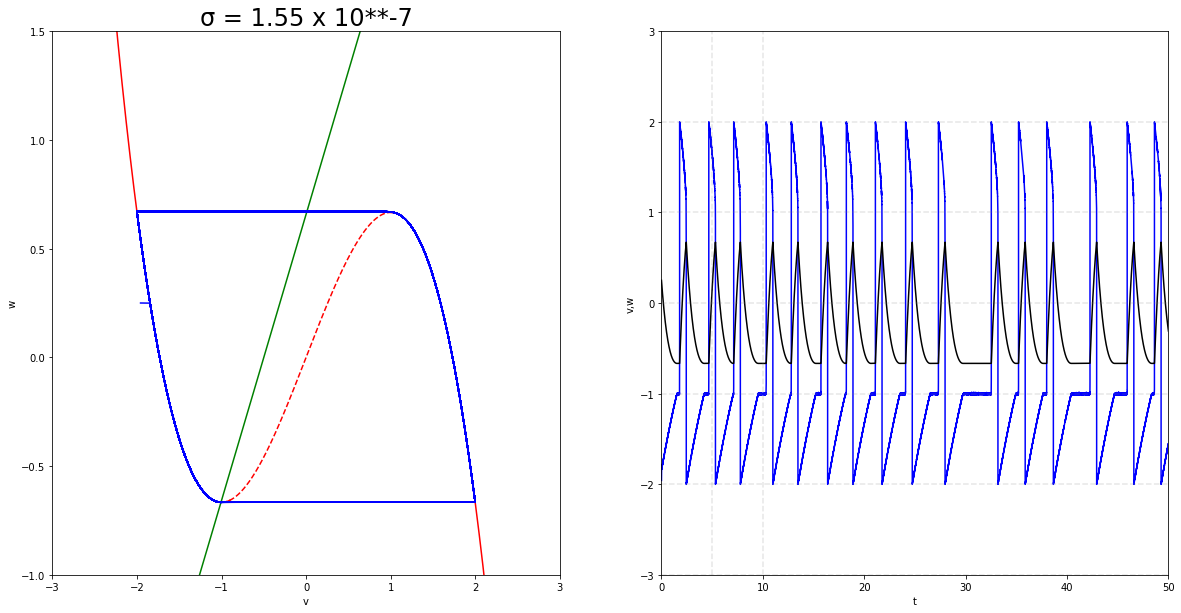

In [9]:
epsilon = 0.0001
eps_t = np.arange(0.0, epsilon*500000.001, epsilon*0.1)
t = np.arange(0.0, 100000.01, 0.1)
params = (0.76, 0.5)
v_vals_1 = np.arange(-3, -0.9, 0.001)
v_vals_2 = np.arange(-1, 1.1, 0.001)
v_vals_3 = np.arange(1, 3, 0.001)
v_vals = np.arange(-3, 3, 0.001)
w_vals = np.arange(-1, 1, 0.001)

fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))

ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.plot(v_vals_1, [vNullcline(v) for v in v_vals_1], color = 'r')
ax.plot(v_vals_2, [vNullcline(v) for v in v_vals_2], color = 'r', linestyle = '--')
ax.plot(v_vals_3, [vNullcline(v) for v in v_vals_3], color = 'r')

ax.plot(v_vals, [wNullcline(params, v) for v in v_vals], color = 'g')

#print(X)
ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1.5)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.plot(X_8[:,0], X_8[:,1], color = 'b')
ax.set_title("σ = 1.55 x 10**-7", fontsize = 24)
#ax.plot(Y[:,0], Y[:,1], color = 'k');

ax2.set_xlim(-0.03, 50)
ax2.set_ylim(-3, 3)
ax2.set_xlabel('t')
ax2.set_ylabel('v,w')
ax2.plot(eps_t, X_8[:,0], color = 'b')
ax2.plot(eps_t, X_8[:,1], color = 'k')

hlines = np.arange(-3, 3, 1)
vlines = np.arange(5, 15, 5)
for i in range(len(hlines)):
    ax2.axhline(hlines[i], color='grey', linestyle = '--', alpha = 0.2)
for i in range(len(vlines)):
    ax2.axvline(vlines[i], color = 'grey', linestyle = '--', alpha = 0.2)
    
np.savetxt("fig9_1.csv", X_8, delimiter=",")
del X_8, ax, ax2, fig, eps_t, v_vals_1, v_vals_2, v_vals_3, v_vals, w_vals

### Parameter tuning

In [16]:
#(c, d, epsilon, sigma) = params 
#def euler_ft_FHN(params, f, g, v0, w0, a, b, h):

c = 1.5 
d = 0.5
epsilon = 0.0001
sigma = 0.075
init_v = -2
init_w = 0.25
t_init = 0.0
t_end = 100000
steps = 0.01
params = (c, d, epsilon, sigma)
try:
    X_9 = np.genfromtxt('fig10_1.csv', delimiter=',')
except:
    X_9 = euler_ft_FHN(params, fast_f, fast_g, init_v, init_w, t_init, t_end, steps)

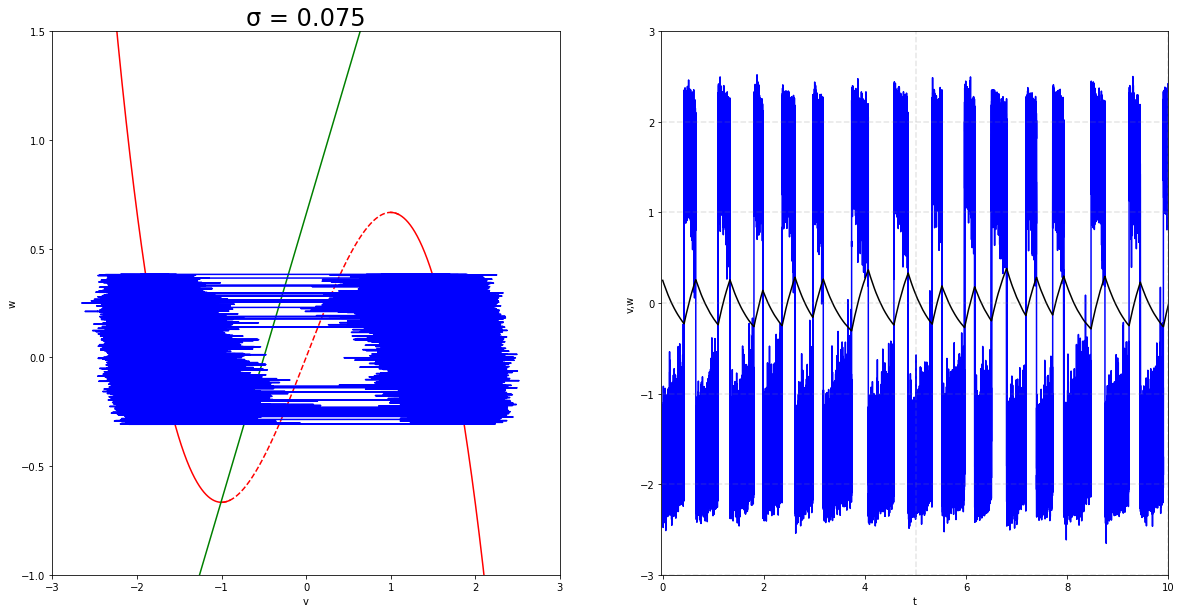

In [18]:
epsilon = 0.0001
eps_t = np.arange(0.0, epsilon*100000.001, epsilon*0.01)
t = np.arange(0.0, 100000.01, 0.1)
params = (0.76, 0.5)
v_vals_1 = np.arange(-3, -0.9, 0.001)
v_vals_2 = np.arange(-1, 1.1, 0.001)
v_vals_3 = np.arange(1, 3, 0.001)
v_vals = np.arange(-3, 3, 0.001)
w_vals = np.arange(-1, 1, 0.001)

fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))

ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.plot(v_vals_1, [vNullcline(v) for v in v_vals_1], color = 'r')
ax.plot(v_vals_2, [vNullcline(v) for v in v_vals_2], color = 'r', linestyle = '--')
ax.plot(v_vals_3, [vNullcline(v) for v in v_vals_3], color = 'r')

ax.plot(v_vals, [wNullcline(params, v) for v in v_vals], color = 'g')

#print(X)
ax.set_xlim(-3, 3)
ax.set_ylim(-1, 1.5)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.plot(X_9[:,0], X_9[:,1], color = 'b')
ax.set_title("σ = 0.075", fontsize = 24)
#ax.plot(Y[:,0], Y[:,1], color = 'k');

ax2.set_xlim(-0.03, 10)
ax2.set_ylim(-3, 3)
ax2.set_xlabel('t')
ax2.set_ylabel('v,w')
ax2.plot(eps_t, X_9[:,0], color = 'b')
ax2.plot(eps_t, X_9[:,1], color = 'k')

hlines = np.arange(-3, 3, 1)
vlines = np.arange(5, 15, 5)
for i in range(len(hlines)):
    ax2.axhline(hlines[i], color='grey', linestyle = '--', alpha = 0.2)
for i in range(len(vlines)):
    ax2.axvline(vlines[i], color = 'grey', linestyle = '--', alpha = 0.2)
    
np.savetxt("fig10_1.csv", X_9, delimiter=",")
del X_9, ax, ax2, fig, eps_t, v_vals_1, v_vals_2, v_vals_3, v_vals, w_vals